# 1. 環境配置

In [ ]:
!pip install pretty_midi tqdm

import os
import sys
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import numpy as np
import pretty_midi
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

REPO_URL = "https://github.com/hirasawahaonycu/2025_ML_finalProject.git"
REPO_NAME = REPO_URL.split("/")[-1].replace(".git", "")

if 'google.colab' in sys.modules:
    if not os.path.exists(REPO_NAME):
        !git clone $REPO_URL
    else:
        !cd $REPO_NAME && git pull
else:
    print("[!] Error 1-1")

def find_data_path(root_dir):
    midis = glob.glob(os.path.join(root_dir, "**/*.mid*"), recursive=True)
    if len(midis) > 10:
        print(f"找到 {len(midis)} 筆 midis 文件")
        return os.path.dirname(os.path.commonprefix(midis))
    return None

repo_data = find_data_path(REPO_NAME) if 'google.colab' in sys.modules else find_data_path("..")

if repo_data:
    DATA_DIR = repo_data
else:
    print("[!] Error 1-2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 74.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=5e326808a118182b42e8fe009e33c07c7cd1be7888847e373e8f96984b89fb5a
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty_midi
Cloning into '2025_ML_finalProject'...
remote: Enumerating objects: 1314, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1314 (delta 2), reused 7 (delta 1), pack-reused 1302 (from 3)
Receiving objects: 100% (1314/1314), 55.35 MiB | 32.22 MiB/s, done.
Resolving deltas: 100% (2/2), done.
找到 1276 筆 midis 文件


# 2. 資料集準備

## 負樣本設計

打亂演示


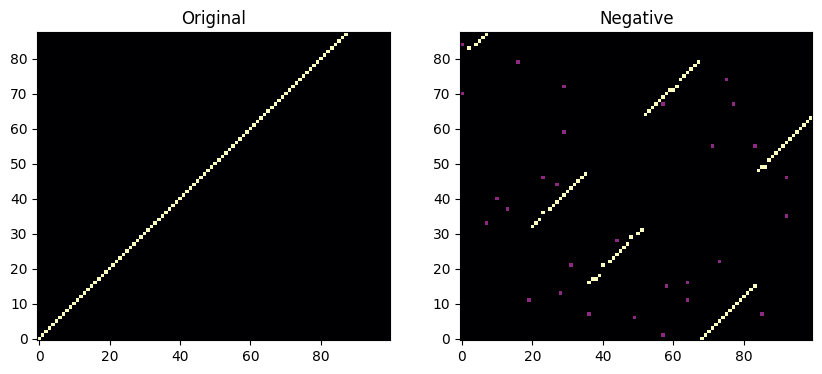

In [4]:
def midi_to_pianoroll(midi_path, fs=10, duration=10):
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
        roll = pm.get_piano_roll(fs=fs)
        roll = roll[21:109, :]
        return roll / 127.0
    except:
        return None

def negative_noise(pianoroll):
    h, w = pianoroll.shape
    fake_roll = pianoroll.copy()

    noise = np.random.rand(h, w)
    mask = noise > 0.997

    fake_roll[mask] = np.clip(fake_roll[mask] + 0.4, 0, 0.8)

    return fake_roll

def negative_shuffle(pianoroll):
    h, w = pianoroll.shape
    fake_roll = pianoroll.copy()

    num_chunks = np.random.randint(4, 9)
    chunk_size = w // num_chunks
    chunks = []
    for i in range(num_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < num_chunks - 1 else w
        chunks.append(fake_roll[:, start:end])
    np.random.shuffle(chunks)
    fake_roll = np.concatenate(chunks, axis=1)

    return fake_roll

def negative_offKey(pianoroll):
    h, w = pianoroll.shape
    fake_roll = pianoroll.copy()

    num_mistakes = np.random.randint(5, 15)
    active_y, active_x = np.where(fake_roll > 0.1)

    if len(active_x) > 0:
        for _ in range(num_mistakes):
            idx = np.random.randint(len(active_x))
            py, px = active_y[idx], active_x[idx]

            duration = np.random.randint(2, 6)
            shift = np.random.choice([-1, 1])

            if 0 <= py + shift < h and px + duration < w:
                segment_val = fake_roll[py, px:px+duration].copy()
                fake_roll[py, px:px+duration] = 0
                fake_roll[py + shift, px:px+duration] = segment_val

    return fake_roll

def negative(pianoroll, typeList=["shuffle", "offKey", "noise"], prob=[]):
    def neg_fun(pianoroll, neg_type):
        if neg_type == "noise":
            pianoroll = negative_noise(pianoroll)
        elif neg_type == "shuffle":
            pianoroll = negative_shuffle(pianoroll)
        elif neg_type == "offKey":
            pianoroll = negative_offKey(pianoroll)
        return pianoroll

    if not typeList:
        print("[!] Error 2-a-1")
        return

    h, w = pianoroll.shape
    fake_roll = pianoroll.copy()

    if len(prob) < len(typeList):
        prob += [1.0] * (len(typeList) - len(prob))

    haveNeg = False
    maxI = 0; maxV = 0.0

    for i in range(len(typeList)):
        if prob[i] > maxV:
            maxI = i
            maxV = prob[i]
        if random.random() <= prob[i]:
            fake_roll = neg_fun(fake_roll, typeList[i])
            haveNeg = True

    if not haveNeg:
        fake_roll = neg_fun(fake_roll, typeList[maxI])

    return fake_roll

def demo_augmentation():
    print("打亂演示")
    h, w = 88, 100
    dummy_real = np.zeros((h, w))
    for i in range(min(h, w)): dummy_real[i, i] = 1.0

    dummy_fake = negative(dummy_real)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(dummy_real, aspect='auto', origin='lower', cmap='magma'); ax[0].set_title("Original")
    ax[1].imshow(dummy_fake, aspect='auto', origin='lower', cmap='magma'); ax[1].set_title("Negative")
    plt.show()

demo_augmentation()

## 生成資料集

In [25]:
class MuseDataset(Dataset):
    def __init__(self, file_list, duration=10, fs=10, split_name="Dataset", samples_per_song=10):
        self.samples = []
        target_width = int(duration * fs)

        for path in tqdm(file_list, desc=f"構建 {split_name}", leave=True):
            full_roll = midi_to_pianoroll(path, fs)
            if full_roll is None: continue

            current_width = full_roll.shape[1]

            if current_width < target_width:
                pad = target_width - current_width
                slice_roll = np.pad(full_roll, ((0,0), (0, pad)))
                self.samples.append(slice_roll)
            else:
                max_slices = current_width // target_width
                all_indices = np.arange(max_slices)

                valid_indices = []
                for i in all_indices:
                    start = i * target_width
                    end = start + target_width
                    if full_roll[:, start:end].max() > 0.01:
                        valid_indices.append(i)

                if not valid_indices:
                    continue

                num_to_pick = min(len(valid_indices), samples_per_song)
                selected_indices = np.random.choice(valid_indices, num_to_pick, replace=False)

                for i in selected_indices:
                    start = i * target_width
                    end = start + target_width
                    slice_roll = full_roll[:, start:end]
                    self.samples.append(slice_roll)

        print(f"{split_name} 建構完成，總共生成 {len(self.samples)} 個片段")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        real = self.samples[idx]
        if np.random.rand() > 0.5:
            data = negative(real, ["shuffle", "offKey", "noise"], [0.95, 0.6, 0.15]); label = 0.0
        else:
            data = real; label = 1.0

        return torch.from_numpy(data).float().unsqueeze(0), torch.tensor([label]).float()

MAX_SONGS = 700
all_files = glob.glob(os.path.join(DATA_DIR, '**/*.mid*'), recursive=True)
random.shuffle(all_files)

if MAX_SONGS < len(all_files):
    all_files = all_files[:MAX_SONGS]

print(f"總共使用歌曲數: {len(all_files)} 首")

n_total = len(all_files)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

train_files = all_files[:n_train]
val_files = all_files[n_train : n_train + n_val]
test_files = all_files[n_train + n_val :]

print(f"   - Train Files: {len(train_files)}")
print(f"   - Val Files:   {len(val_files)}")
print(f"   - Test Files:  {len(test_files)}")

print("\n正在構建訓練集...")
train_ds = MuseDataset(train_files, split_name="trainSet")

print("\n正在構建驗證集...")
val_ds = MuseDataset(val_files, split_name="validSet")

print("\n正在構建測試集...")
test_ds = MuseDataset(test_files, split_name="testSet")


總共使用歌曲數: 700 首
   - Train Files: 560
   - Val Files:   70
   - Test Files:  70

正在構建訓練集...


構建 trainSet:   0%|          | 0/560 [00:00<?, ?it/s]

trainSet 建構完成，總共生成 5562 個片段

正在構建驗證集...


構建 validSet:   0%|          | 0/70 [00:00<?, ?it/s]

validSet 建構完成，總共生成 700 個片段

正在構建測試集...


構建 testSet:   0%|          | 0/70 [00:00<?, ?it/s]

testSet 建構完成，總共生成 700 個片段


# 3. 模型設計

In [41]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        outputs = torch.bmm(weights.unsqueeze(1), encoder_outputs)
        return outputs.squeeze(1)

class MusicCritic(nn.Module):
    def __init__(self):
        super().__init__()

        self.entry = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,5), padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,1))
        )

        self.res_blocks = nn.Sequential(
            ResidualBlock(64),
            nn.MaxPool2d((2,1)),
            ResidualBlock(64),
            nn.MaxPool2d((2,1)),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d((2,1))
        )

        self.rnn = nn.LSTM(640, 256, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.attention = SelfAttention(256 * 2)
        self.clf = nn.Sequential(
            nn.Linear(512, 128), nn.LeakyReLU(0.1), nn.Dropout(0.4),
            nn.Linear(128, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.entry(x)
        x = self.res_blocks(x)

        x = x.permute(0, 3, 1, 2)
        B, T, C, H = x.shape
        x = x.reshape(B, T, C * H)

        r_out, _ = self.rnn(x)
        ctx = self.attention(r_out)
        return self.clf(ctx)

# 4. 訓練

In [45]:
BATCH_SIZE = 128
LR = 0.001
EPOCHS = 30

history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = MusicCritic().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR)
crit = nn.BCELoss()
best_acc = 0.0

print(f"Training Start | Train: {len(train_ds)} | Val: {len(val_ds)}")

total_steps = EPOCHS * len(train_dl)

with tqdm(total=total_steps, unit="batch") as pbar:
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for x, y in train_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

            pbar.update(1)
            pbar.set_postfix({
                'Ep': f"{epoch+1}/{EPOCHS}",
                'Loss': f"{loss.item():.4f}",
                'BestAcc': f"{best_acc:.1f}%"
            })

        avg_train_loss = epoch_loss / len(train_dl)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0
        correct = 0; total = 0
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x)
                val_loss += crit(pred, y).item()
                correct += ((pred > 0.5).float() == y).sum().item()
                total += y.size(0)

        avg_val_loss = val_loss / len(val_dl)
        acc = 100 * correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_model.pth")

print(f"\n訓練完成，最佳acc: {best_acc:.2f}%")

Training Start | Train: 5562 | Val: 700


  0%|          | 0/1320 [00:00<?, ?batch/s]


訓練完成，最佳acc: 89.71%


# 5. 訓練結果可視化

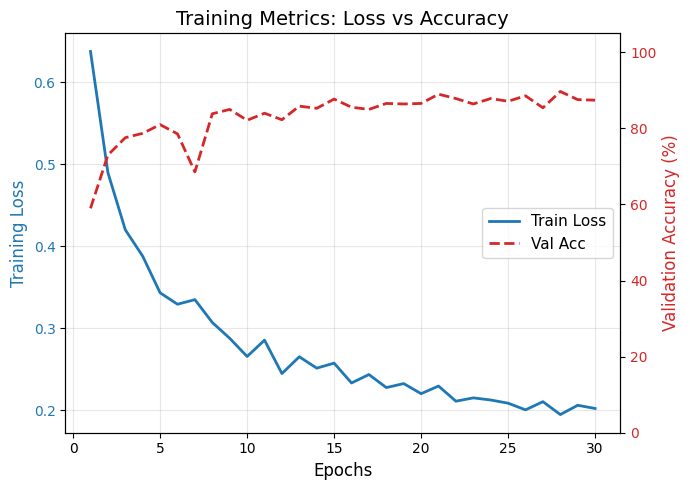

In [46]:
def plot_history_dual(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(7, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Training Loss', color=color, fontsize=12)
    line1 = ax1.plot(epochs, history['train_loss'], color=color, linewidth=2, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Validation Accuracy (%)', color=color, fontsize=12)
    line2 = ax2.plot(epochs, history['val_acc'], color=color, linewidth=2, linestyle='--', label='Val Acc')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 105)

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right', fontsize=11)

    plt.title('Training Metrics: Loss vs Accuracy', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_history_dual(history)

# 6. 測試集結果

In [47]:
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for x, y in tqdm(test_dl, desc="Testing"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = (model(x) > 0.5).float()
        test_correct += (pred == y).sum().item()
        test_total += y.size(0)

final_acc = 100 * test_correct / test_total

print("="*40)
print(f"測試集準確率 (Test Accuracy): {final_acc:.2f}%")
print("="*40)

Testing:   0%|          | 0/6 [00:00<?, ?it/s]

測試集準確率 (Test Accuracy): 92.71%


# 7. 專項測試

In [52]:
def specialized_test(eachNum=10, testList=["shuffle", "offKey", "noise"]):
    if 'model' not in globals() or 'test_ds' not in globals():
        print("[!] Error 7-1")
        return

    if len(test_ds) == 0:
        print("[!] Error 7-2")
        return

    if os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
    model.eval()

    total_indices = len(test_ds)
    required_samples = len(testList) * eachNum
    if required_samples > total_indices:
        print(f"警告: 測試樣本不足 (需 {required_samples}, 僅有 {total_indices})，將開啟重複採樣。")
        selected_indices = np.random.choice(total_indices, required_samples, replace=True)
    else:
        selected_indices = np.random.choice(total_indices, required_samples, replace=False)

    print("=" * 51)
    print(f"{'Attack Type':<15} | {'Detection Rate':<15} | {'Avg Score':<15}")
    print("-" * 51)

    current_idx_ptr = 0

    for attack_type in testList:
        batch_indices = selected_indices[current_idx_ptr : current_idx_ptr + eachNum]
        current_idx_ptr += eachNum

        scores = []
        detected_count = 0

        for idx in batch_indices:
            real = test_ds.samples[idx]
            fake = negative(real, [attack_type], [1.0])
            inp = torch.from_numpy(fake).float().unsqueeze(0).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                score = model(inp).item()

            scores.append(score)
            if score < 0.5:
                detected_count += 1

        detection_rate = (detected_count / eachNum) * 100
        avg_score = np.mean(scores)

        print(f"{attack_type:<15} | {detection_rate:>14.1f}% | {avg_score:>15.4f}")

specialized_test(len(test_ds)//4)

Attack Type     | Detection Rate  | Avg Score      
---------------------------------------------------
shuffle         |           76.6% |          0.2362
offKey          |           90.3% |          0.0824
noise           |           94.9% |          0.0537


# 8. 可視化測試

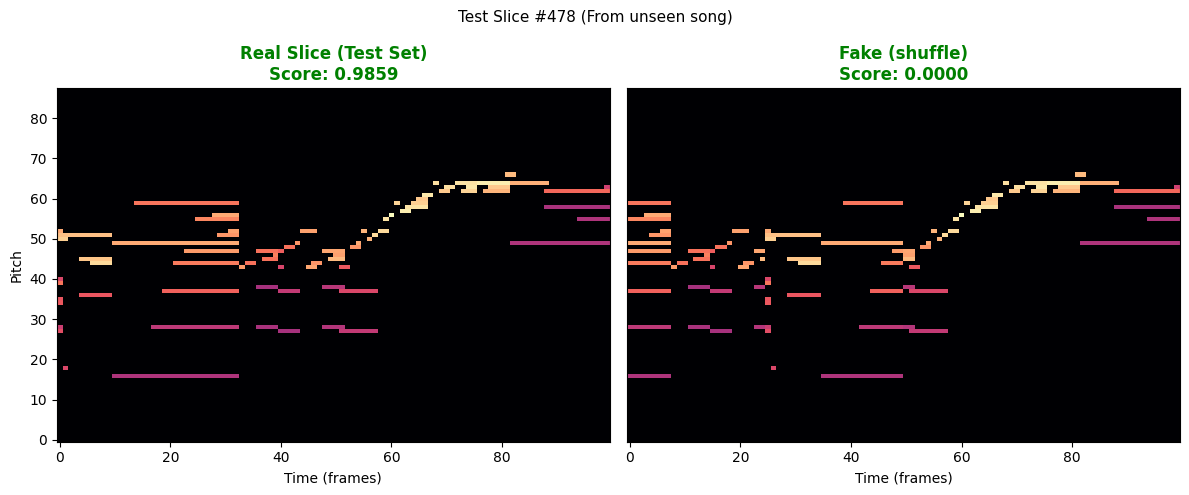

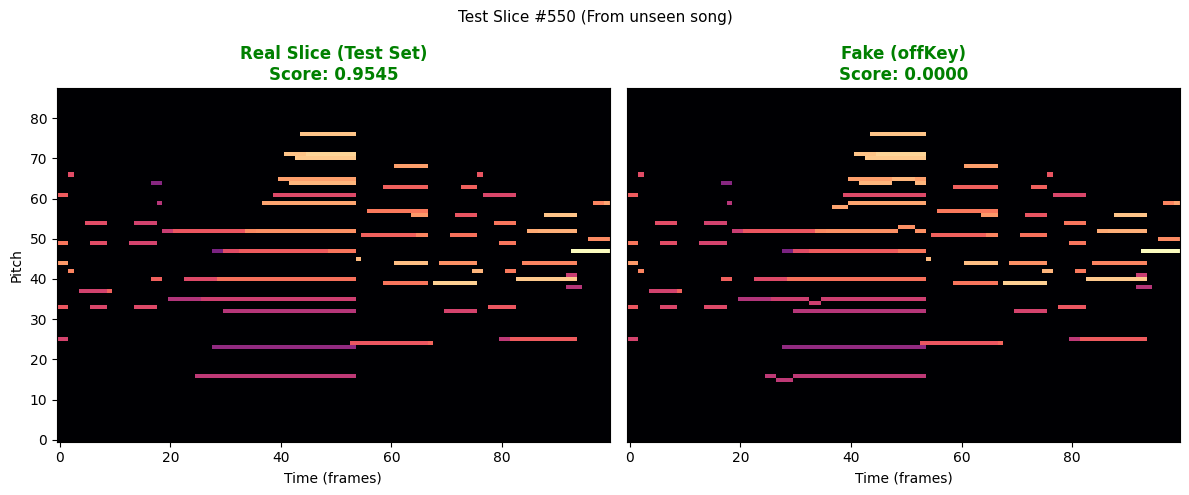

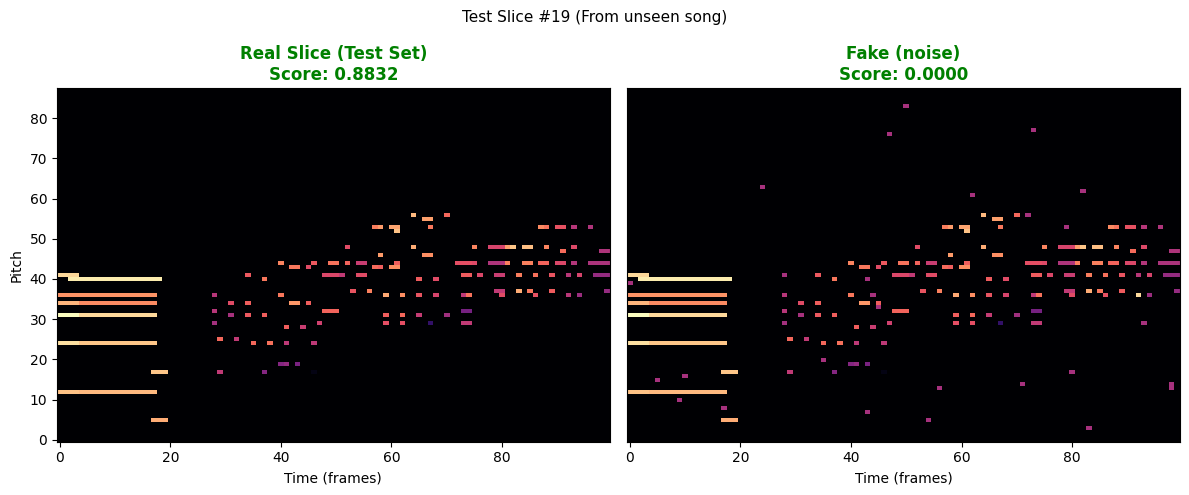

In [53]:
def visualize_test_slices(testList=["shuffle", "offKey", "noise"]):
    if 'model' not in globals() or 'test_ds' not in globals():
        print("[!] Error 8-1")
        return

    if len(test_ds) == 0:
        print("[!] Error 8-2")
        return

    if os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
    model.eval()

    total_indices = len(test_ds)
    selected_indices = np.random.choice(total_indices, len(testList), replace=False)

    for i, idx in enumerate(selected_indices):
        real = test_ds.samples[idx]
        fake = negative(real, [testList[i]], [1.0])
        inp = torch.tensor(np.stack([real, fake])).float().unsqueeze(1).to(DEVICE)

        with torch.no_grad():
            scores = model(inp).cpu().numpy().flatten()

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        c_real = "green" if scores[0] > 0.8 else "red"
        c_fake = "green" if scores[1] < 0.2 else "red"

        ax[0].imshow(real, aspect='auto', origin='lower', cmap='magma')
        ax[0].set_title(f"Real Slice (Test Set)\nScore: {scores[0]:.4f}", color=c_real, fontweight='bold')
        ax[0].set_ylabel("Pitch")
        ax[0].set_xlabel("Time (frames)")

        ax[1].imshow(fake, aspect='auto', origin='lower', cmap='magma')
        ax[1].set_title(f"Fake ({testList[i]})\nScore: {scores[1]:.4f}", color=c_fake, fontweight='bold')
        ax[1].set_xlabel("Time (frames)")
        ax[1].set_yticks([])

        plt.suptitle(f"Test Slice #{idx} (From unseen song)", fontsize=11)
        plt.tight_layout()
        plt.show()

visualize_test_slices()

# 9. 導出模型

In [54]:
if not os.path.exists("best_model.pth"):
    print("找不到模型文件，請先訓練！")
else:
    size = os.path.getsize('best_model.pth') / 1024 / 1024
    print(f"模型就緒: best_model.pth ({size:.2f} MB)")

    if 'google.colab' in sys.modules:
        from google.colab import files
        files.download('best_model.pth')
    else:
        print("本地環境：文件已在當前目錄。")

模型就緒: best_model.pth (14.28 MB)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>